

# Plot genome coverage for subsampled reads

> - author: Peter Kruczkiewicz
> - date:  2021-08-30

This Jupyter Notebook is for generating line plots of genome coverage for reads subsampled from input BAM files for different samples, i.e. what is the genome coverage at a particular depth if you were to randomly subsample 1 to X reads for a particular sample.

## Dependencies

Install dependencies with:

```bash
pip install numpy=1.21.2 pandas pysam tqdm seaborn matplotlib plotnine
```

## Parameters

- `inputdir`: directory with BAM files with reads mapped to a common reference. *Make sure the unmapped reads are **NOT** filtered out (i.e. no `samtools view -F4 ...`)
- `depth`: min depth threshold for calculating genome coverage (default 10X coverage; change as required)
- `n_subsampled_reads`: number of reads to subsample from BAM files for plotting.

In [1]:
# input params for notebook
# adjust as needed
n_subsampled_reads = 30000
depth = 10
inputdir = './'

Imports for getting BAM files from `inputdir` and parsing BAM files

In [2]:
from typing import Tuple, Dict, List, Iterable
from collections import defaultdict
from pathlib import Path

import logging

import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm.notebook import tqdm
import pysam

Should be using a recent version of numpy like version 1.21.2

In [3]:
np.__version__

'1.21.2'

In [4]:
def get_read_mapping_coords(bam: pysam.libcalignmentfile.AlignmentFile) -> Dict[str, List[Tuple[int, int]]]:
    """Get coordinates for all reads.
    
    Unmapped reads will be present in output dict and have empty list of mapping coordinates.
    """
    out = defaultdict(list)
    for x in tqdm(bam.fetch(until_eof=True)):
        if x.is_unmapped:
            out[x.qname] = []
        else:
            out[x.qname].append((x.reference_start, x.reference_end))
    return out


def genomecov(reads: Iterable[str], 
              mapped: Dict[str, List[Tuple[int, int]]], 
              ref_len: int, 
              depth: int = 10) -> npt.NDArray[np.uint32]:
    """Get array of number of reference genome positions covered with at least `depth` X coverage adding one read at a time from `reads`."""
    out = np.zeros(len(reads))
    arr = np.zeros(ref_len, dtype=np.uint32)
    for idx, read in tqdm(enumerate(reads)):
        mapping_coords = mapped[read]
        if len(mapping_coords) == 2:
            (r1s, r1e), (r2s, r2e) = mapping_coords
            arr[r1s:r1e] = arr[r1s:r1e] + 1
            arr[r2s:r2e] = arr[r2s:r2e] + 1
        elif len(mapping_coords) == 1:
            r1s, r1e = mapping_coords[0]
            arr[r1s:r1e] = arr[r1s:r1e] + 1
        elif len(mapping_coords) == 0:
            continue
        else:
            print(idx, read, mapping_coords)
            continue
        out[idx] = (arr >= depth).sum()
    return out


def sample_read_ids(read_ids: Iterable[str], n: int = 50000) -> npt.NDArray[np.unicode_]:
    """Random sampling of read IDs"""
    return np.random.choice(read_ids, size=n, replace=False)


def subsampled_genomecov(
    bam_path: Path,
    n_subsampled: int = 50000,
    depth: int = 10
) -> Tuple[str, int, npt.NDArray[np.uint32]]:
    bam = pysam.AlignmentFile(bam_path)
    logging.info(f'Opened BAM file "{bam_path}" with pysam: {bam}')
    ref_name = bam.references[0]
    ref_len = bam.get_reference_length(ref_name)
    logging.info(f'Reference "{ref_name}" with length {ref_len}')
    logging.info(f'Getting read ids and mapping coordinates from "{bam_path}"')
    read_coords = get_read_mapping_coords(bam)
    read_ids = list(read_coords.keys())
    logging.info(f'{len(read_ids)} read IDs parsed')
    subsampled_read_ids = sample_read_ids(read_ids, n_subsampled)
    logging.info(f'Subsampled {len(subsampled_read_ids)} read IDs for genome coverage calculation. Calculating genome coverage at {depth}X from subsampled reads.')
    gcov_positions = genomecov(subsampled_read_ids, read_coords, ref_len, depth=depth)
    gcov_proportion = gcov_positions / ref_len
    return gcov_proportion

In [5]:
logging.basicConfig(level=logging.INFO)

Look for bam files in input directory

In [6]:
inputdir = Path(inputdir)
bam_paths = list(inputdir.glob('*.bam'))

In [7]:
bam_paths

[PosixPath('Sample1.bam'), PosixPath('Sample2.bam')]

Get genome coverage for each sample/BAM file

In [8]:

sample_gcov = {}
for p in bam_paths:
    sample_gcov[p.stem] = subsampled_genomecov(p, n_subsampled=n_subsampled_reads, depth=depth)

INFO:root:Opened BAM file "Sample1.bam" with pysam: <pysam.libcalignmentfile.AlignmentFile object at 0x7f82f839e3a0>
INFO:root:Reference "MN908947.3" with length 29903
INFO:root:Getting read ids and mapping coordinates from "Sample1.bam"


INFO:root:601441 read IDs parsed
INFO:root:Subsampled 30000 read IDs for genome coverage calculation. Calculating genome coverage at 10X from subsampled reads.


INFO:root:Opened BAM file "Sample2.bam" with pysam: <pysam.libcalignmentfile.AlignmentFile object at 0x7f82abfdfa60>
INFO:root:Reference "MN908947.3" with length 29903
INFO:root:Getting read ids and mapping coordinates from "Sample2.bam"


INFO:root:601462 read IDs parsed
INFO:root:Subsampled 30000 read IDs for genome coverage calculation. Calculating genome coverage at 10X from subsampled reads.


# Figures start here

Manual way using matplotlib directly

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.scale as mscale
import seaborn as sns

In [10]:
sns.set_theme(context='talk', style='white', )

In [11]:
def color_palette_cycle(palette='Set1'):
    set1 = list(sns.color_palette(palette))
    i = 0
    while True:
        if i >= len(set1):
            i = 0
        yield set1[i]
        i += 1

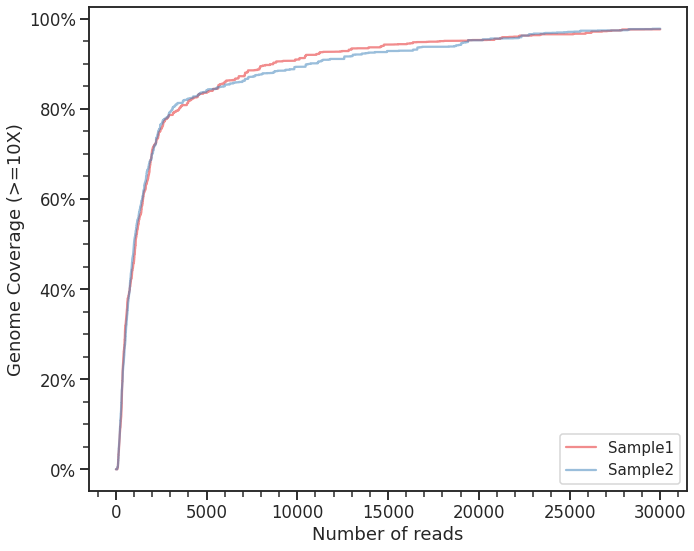

In [12]:
fig, ax1 = plt.subplots(figsize=(10,8))

for color, (sample, gcov) in zip(color_palette_cycle(), sample_gcov.items()):
    idx = range(len(gcov))
    ax1.plot(idx, gcov * 100, color=color, label=sample, alpha=0.5)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_minor_locator(mtick.AutoMinorLocator())
ax1.yaxis.set_minor_locator(mtick.AutoMinorLocator())
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax1.set_ylabel(f'Genome Coverage (>={depth}X)')
ax1.set_xlabel('Number of reads')

ax1.legend(loc=4, fontsize='small')

fig.tight_layout()
plt.show()

## Plots using plotnine (ggplot2 for Python)

This is a more "ggplot2" like approach with similar results as above. The data just needs to be transformed into a Pandas DataFrame prior to using with plotnine.

Install plotnine with:

```bash
pip install plotnine
```

In [13]:
def gcovs_to_df(sample_gcov: Dict[str, np.ndarray]) -> pd.DataFrame:
    dfs = []
    for sample, gcov in sample_gcov.items():
        df = pd.DataFrame(zip(range(1, len(gcov)+1), gcov))
        df.columns = ['n_reads', 'genome_coverage']
        df['sample'] = sample
        dfs.append(df)
    return pd.concat(dfs)

In [14]:
df = gcovs_to_df(sample_gcov)

In [15]:
df

,n_reads,genome_coverage,sample
0,1,0.000000,Sample1
1,2,0.000000,Sample1
2,3,0.000000,Sample1
3,4,0.000000,Sample1
4,5,0.000000,Sample1
...,...,...,...
29995,29996,0.977862,Sample2
29996,29997,0.977862,Sample2
29997,29998,0.977862,Sample2
29998,29999,0.977862,Sample2


In [16]:
from plotnine import *

In [17]:
df.genome_coverage = df.genome_coverage * 100

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


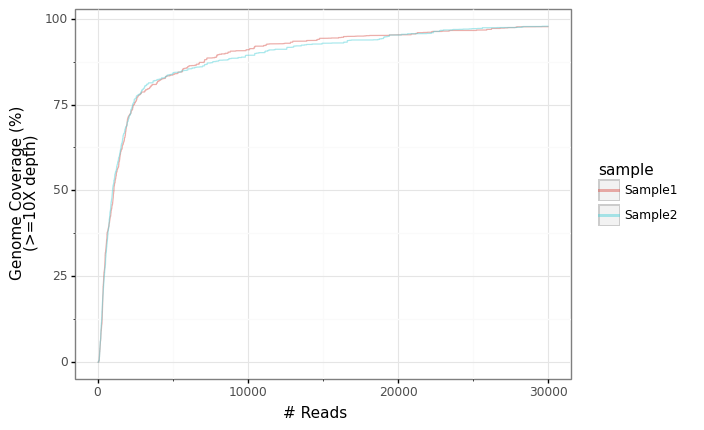

<ggplot: (8762430651353)>

In [18]:
(ggplot(df, aes(x='n_reads', y='genome_coverage')) 
 + theme_bw()
 + geom_line(aes(color='sample'), alpha=0.5)
 + theme(axis_ticks_minor=element_line(color='gray', size=0.5))
 + xlab('# Reads')
 + ylab('Genome Coverage (%)\n(>=10X depth)')
)